In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def emission_height(P, hmin, hmax, ncomp):
    """Function to determine the emission heights given hmin and hmax. Allowed emision heights for young 
       pulsars range between [950, 1000] and between [20, 1000] for old pulsars.
    
       Args:
       -----
       P      : rotational period.
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       ncomp  : integer number of component .
       
       Returns:
       --------
       H      : random emission height.
    """
    
#   num_H = np.random.randint(3,8), number of discrete emission height 
    num_H = ncomp
    
#   emission height for a short period pulsar: only one emission height 
    if P <= 0.15:
        if hmin >= 950 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=1)
            
        else: print "error, emission range not allowed for pulse period P < 0.15 seconds"
            
#   emission height for a long period pulsar:        
    if P > 0.15:
        if hmin >= 20 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=num_H)
        
        else: print "error, emission range not allowed for pulse period P > 0.15 seconds"
        
    return H

########################### simple test #############################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 1000
    ncomp = 4
    heights = emission_height(P, hmin, hmax, ncomp)
    print heights  

[ 587.13364573  828.91441278  248.58151237  730.09533199]


[ -2.00000000e+01  -1.99984368e+01  -1.99937476e+01  -1.99859340e+01
  -1.99749986e+01  -1.99609449e+01  -1.99437774e+01  -1.99235017e+01
  -1.99001245e+01  -1.98736534e+01  -1.98440969e+01  -1.98114646e+01
  -1.97757672e+01  -1.97370163e+01  -1.96952245e+01  -1.96504052e+01
  -1.96025732e+01  -1.95517439e+01  -1.94979338e+01  -1.94411604e+01
  -1.93814421e+01  -1.93187983e+01  -1.92532492e+01  -1.91848161e+01
  -1.91135211e+01  -1.90393874e+01  -1.89624390e+01  -1.88827006e+01
  -1.88001982e+01  -1.87149583e+01  -1.86270085e+01  -1.85363773e+01
  -1.84430937e+01  -1.83471879e+01  -1.82486909e+01  -1.81476342e+01
  -1.80440506e+01  -1.79379732e+01  -1.78294363e+01  -1.77184746e+01
  -1.76051238e+01  -1.74894202e+01  -1.73714010e+01  -1.72511040e+01
  -1.71285677e+01  -1.70038313e+01  -1.68769346e+01  -1.67479183e+01
  -1.66168235e+01  -1.64836920e+01  -1.63485662e+01  -1.62114893e+01
  -1.60725047e+01  -1.59316567e+01  -1.57889900e+01  -1.56445500e+01
  -1.54983823e+01  -1.53505334e+01

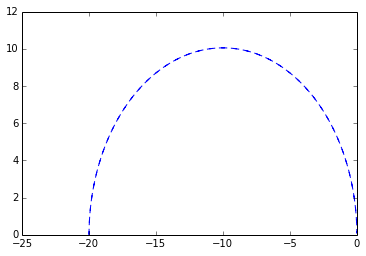

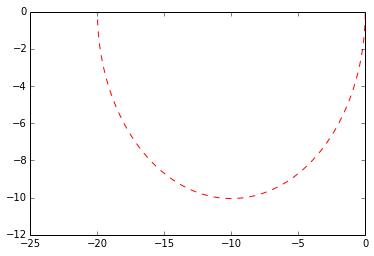

In [3]:
import mapphi as mp
def los(alpha, beta):
    """Function to determine the line of sight cut across the beam.
    
       Args:
       -----
       alpha       : inclination angle
       beta        : impact parameter
       
       Returns:
       --------
       xlos        : the line of sight x-coordinates
       ylos        : the line of sight y-coordinates
       avgthetalos : the line of sight angle in degrees
    """

#   rotational phase:
    phi = np.linspace(-180, 180, num=360, endpoint=True)
    
#   line of sight x,y plane:
    xlos, ylos = mp.mapphi(alpha, beta, phi)
    thetalos = np.arctan2(ylos, xlos) * (180 / np.pi) - 90.0
    for i in np.arange(len(thetalos)):
        if thetalos[i] < 0:
            thetalos[i] = -thetalos[i]
            
#   find the average thetalos
    avgthetalos = np.average(thetalos)
    
    #for i in np.arange(180):
        
    return xlos, ylos, avgthetalos
################## test ######################
if __name__ == "__main__":
    alpha = 10.
    beta = 0
    xlos, ylos, avgthetalos = los(alpha, beta)
    plt.plot(xlos, ylos, 'b--')
    plt.figure()
    plt.plot(xlos[180:], -ylos[180:], 'r--')
    print xlos, '\n', ylos
    

In [4]:
def scatter(prof,dm,period,freq):
    """
    Function to perform convolution for a scattered profile. If dm = 0, the function
    returns the input profile without convolution. 
    
    Args:
    -----

        prof   : an array of the profile
        dm     : dispersion measure in cm^-3 pc.
        period : rotational period in seconds.
        freq   : observing frequency in GHz.

    Returns:
    --------

        conv   : convolution of the profile.

    """

    if dm != 0:
        
        #npts = float(prof.shape[0])
        npts = float(len(prof))
        tbin = (period * 1000) / npts    # tbin = time of each bin in ms.
        log_tau = -6.46 + 0.154 * np.log10(dm) + 1.07 * (np.log10(dm))**2 - 3.86 * np.log10(freq)
#       tau = scattering time scale as in Bhat et al. (2004) in ms.
        tau = 10**log_tau
        tcrit = -tau / np.log(0.01)
        bincrit = tcrit / tbin

        verbose = raw_input('verbose (y/n)? : ')
        if verbose is 'y':
            print "Scattering for tau = " + str(tau) + ", dm = " + str(dm) + \
            ", period = " + str(period) + ", freq = " + str(freq) + ", tbin = " + str(tbin)
        

        if bincrit > 10 * npts: bincrit = 10 * npts

        if bincrit < npts: bincrit = npts

        if verbose is 'y': print "Critical bin: " + str(bincrit)
        
#       Convolution:
#       1. Transpose the profile:
        
        tprof = prof[::-1]

#       2. Slide along the time axis for as long as the scatter response is still high enough
#          (tb = straight bin number, tbf = folded bin number)
        tb = 0
        tbf = 0
        
        conv = np.zeros(int(npts))
        #scr = np.zeros(int(npts))
        while tb < bincrit + npts - 1:

            #print tbf, conv.shape, npts, bincrit+npts-1
            #the loops slows down the program
            for i in np.arange(int(npts) - 1):
               
                if tb + i - 1 > npts:
                    frac = (tb + i - 1 - npts) * tbin / tau
                    scr = np.exp(-frac)
                else: 
                    scr = 0.

                #conv[tbf] = tprof[i] * scr[i]
                conv[tbf] += tprof[i] * scr

            tb += 1
            tbf += 1
            if tbf > int(npts) - 1: tbf=1 
       
    
    if dm == 0.: 
        print('No scattering for dm == 0; returning the profile without convolution!')
        conv = prof 
    return conv

###############################################################################################
#simple test statement

if __name__ == "__main__":
    prof = np.arange(200)
    dm = 200
    period = 0.5
    freq = 0.3
    aa = scatter(prof, dm, period, freq)
    print aa

verbose (y/n)? : n
[    0.          2670.53056018  2685.17517842  2699.81979862  2528.18442491
  2368.45599936  2219.87343436  2081.72429076  1953.34166821  1834.10129443
  1723.41880034  1620.74716953  1525.57435067  1437.42102255  1355.838502
  1280.4067855   1210.73271599  1146.44826687  1087.20893565  1032.69224032
   982.59631179   936.63857633   894.5545222    856.09654519   821.03286781
   789.14652772   760.23443074   734.10646438   710.58466806   689.50245639
   670.70389205   654.04300517   639.38315622   626.59643961   615.56312545
   606.1711369    598.31556108   591.89819105   586.82709725   583.01622621
   580.38502499   578.85808952   578.36483557   578.83919061   580.21930543
   582.44728422   585.46893183   589.23351726   593.6935522    598.80458379
   604.52500056   610.81585085   617.64067276   624.96533503   632.75788806
   640.98842445   649.62894846   658.65325385   668.03680945   677.75665213
   687.79128655   698.12059133   708.72573126   719.58907506   730.6941

verbose (y/n)? : n
None


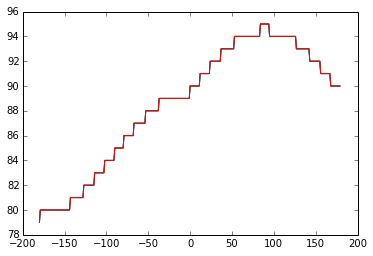

In [5]:
def prof(alpha, beta):
    """Function to compute the profile in I, Q, U, V from the beam.
    
       Args:
       -----
       xlos   : the line of sight x-coordinates
       ylos   : the line of sight y-coordinates
    
       Return:
       -------
       profi  : profile in i
       profq  : profile in q
       profu  : profile in u
       profv  : profile in v
       
    """
    
    
#   initialize the parameters:

    profi = [] # all prof-i,q,u,v should all be np.arrays and not list to work with scatter.py
    profq = []
    profu = []
    profv = []
    profl = []
    x = 180
    x0 = -180
    y = 180
    y0 = -180
    dx = (x - x0) / 180.
    dy = (y - y0) / 180.
    
#   get the line of sight:
    xlos, ylos, thetalos = los(alpha, beta)
#    print len(xlos), dx

#   compute the profiles:
    for i in np.arange(180):
        xind = int((xlos[i] - x0) / dx)
        profi.append(xind)
        profq.append(xind)
        profu.append(xind)
        profv.append(xind)
        
    for i in np.arange(180):
        yind = int((ylos[i] - y0) / dy)
        profi.append(yind)
        profq.append(yind)
        profu.append(yind)
        profv.append(yind)
    #print len(profi), profi
 
    for i in np.arange(-180,180):
        profl.append(np.sqrt(((profq[i])**2 + (profu[i])**2)))
        
    sprofi = scatter(profi, dm, period, freq) 
    #print sprofi   
    #print len(profl), len(profq)
      
    
    #profl = np.sqrt(((profq)**2 + (profu)**2))
    plt.plot(np.arange(-180, 180), profi)
    plt.plot(np.arange(-180, 180), profu)
    plt.plot(np.arange(-180, 180), profv)
    #plt.plot(np.arange(-180, 180), profl)
    #return #profi # profq, profu, profv, prof
    return
######################### test ###########################
if __name__ == "__main__":
    print prof(alpha, beta)

In [6]:
from scipy import constants
#import emission_height

def rho(P, heights):
    """Function to determine the opening angle rho given the rotational period and emission height.
       
    
       Args:
       -----
       P         : rotational period (seconds)
       heights   : emission heights (km)
       
       Returns:
       --------
       rho       : the opening angle (degrees)
       
    """

#   opening angle (eqn 3.29, Lorimer and Kramer 2005):
    rho = np.rad2deg(np.sqrt((9 * np.pi * heights) / (2 * (constants.c / 1000) * P)))   
    
    return rho

#################### simple test #####################################
if __name__ == "__main__":
    opa = rho(P, heights)
    print opa

[ 17.31628739  15.87266669  25.87687394  21.5593591 ]


In [7]:
def patch_width(P, heights):
    """Function to calculate the width of a patchy emission region 
       within a pulsar beam at a given height.
    
       Args:
       -----
       P             : rotational period (seconds).
       heights       : emission heights (km).
      
       
       Returns:
       --------
       patchwidths   : the width of the patchy emission region (degrees).
       
    """   
    
#   width of the patch (eqn 3, KJ2007):
    patchwidths = 2.45 * 0.2 * np.sqrt(heights / ( 10 * P)) 
    
    return patchwidths
#################### simple test ################################################
if __name__ == "__main__":
    patchwidths = patch_width(P, heights)
    print patchwidths



[  6.81957627   6.25104323  10.19094402   8.49060139]


In [8]:
def patch_center(P, heights):
    """Function find centres of the patches
       
       Args:
       -----
       P       : rotatinal period
       heights : emission heights (in km).
       
       
       Returns:
       --------
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
    """
    
#   opening angle:    
    opa = rho(P, heights) 
    
#   initialize the array:
    centerx = []
    centery = []
    
    for comp in opa: #for each emission height (comp!)
#       number of active patches (table 2, KJ2007): 
        npatch = np.random.randint(2,10+1)
        tempCenterX = []
        tempCenterY = []
#       The angle between the axis:
        theta = 2 * np.pi * np.random.random(npatch)

#       centers for short periods:
        if P <= 0.15:
            if hmin >= 950 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
                
#       centers for longer periods:
        if P > 0.15:
            if hmin >= 20 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
        centerx.append(tempCenterX)
        centery.append(tempCenterY)
        
    return centerx, centery

########################### simple test ###########################
if __name__ == "__main__":
    cx, cy = patch_center(P, heights)
    for i in range(len(cx)):
        print 'height %i:\n'%i, cx[i], '\n', cy[i], '\n'

height 0:
[-8.9237981550458656, 10.166336975151555, 4.6025173427370971, -16.404898051607226, 17.118659388688723, 16.68151110048673] 
[14.839799033573044, -14.017824416666866, -16.693431132593435, 5.5437468182817309, 2.6086988333065286, 4.645535090080946] 

height 1:
[-13.789303243914699, 13.547020964575083, -14.81803996703011, -8.8428828319391481, 12.084333346761511, 7.6808987317795365, 15.40123267412654, 0.53826561155234309, -12.93136876463473] 
[7.8610854243411676, -8.2716244466724156, 5.6892213471549731, -13.181235572662429, 10.291279588358938, 13.890476689933037, -3.8397369856336092, -15.863537377673548, -9.2044146948328454] 

height 2:
[23.439188800095572, -19.402735013214027] 
[10.964352849637706, 17.121520931999079] 

height 3:
[-5.75584570633547, -21.303602921394127, -5.4195770572312876, 8.2730779215046155] 
[-20.776818938282904, 3.3109617268852642, -20.867058956883785, -19.908845940788343] 



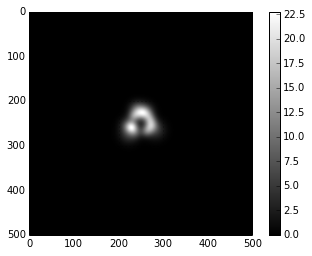

In [9]:
#import d2r
def plotpatch(P, alpha, beta, heights, centerx, centery):
    """Function to plot the patches for a given height range. Using a 2d gaussian
    
       Args:
       -----
       P       : rotational period (seconds)
       alpha   : inclination angle (degrees)
       beta    : impact parameter (degrees)
       heights : emission heights (in km)
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
       
       Returns:
       --------
       A plot of the patches projected on to observational plane.
    
    """    
    
#   make a 2D array:
    x = np.linspace(-180, 180, num=500, endpoint=True)
    y = np.linspace(-180, 180, num=500, endpoint=True)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)

#   find the width of the patches
    patchwidths = patch_width(P, heights)
    
#   An arbitrary peak of the 2D gaussian:
    peak = 5.
    for cid, comp in enumerate(heights):
#       same xy widths for circular patches:        
        sigmax = patchwidths[cid]
        sigmay = patchwidths[cid]
    
#       center of the patch:
        patchCenterX = centerx[cid]
        patchCenterY = centery[cid]
        
#       2D gaussian:
        for pc in zip(patchCenterX, patchCenterY):
            Z += peak*np.exp(-((X - pc[0])**2 / (2*sigmax**2) + (Y - pc[1])**2 / (2*sigmay**2)))
    
    
    fig1 = plt.figure()    
    #plt.contour(X, Y, Z)
    #plt.xlim(-90, 90)
    #plt.ylim(-90, 90)
    plt.grid()
    plt.imshow(Z, cmap=cm.gray)
    plt.colorbar()
   
    
    
############################ simple test ##########################
if __name__ == "__main__":
    alpha = 10
    beta = 1
    plotpatch(P, alpha, beta, heights, cx, cy)